## Prediction of Revenue Per Click

### Hardware details:

We are using AWS `t2.xlarge` instance with following specs:

In [1]:
!sudo lshw -short

H/W path    Device  Class      Description
                    system     HVM domU
/0                  bus        Motherboard
/0/0                memory     96KiB BIOS
/0/401              processor  Intel(R) Xeon(R) CPU E5-2676 v3 @ 2.40GHz
/0/402              processor  CPU
/0/403              processor  CPU
/0/404              processor  CPU
/0/1000             memory     16GiB System Memory
/0/1000/0           memory     16GiB DIMM RAM
/0/100              bridge     440FX - 82441FX PMC [Natoma]
/0/100/1            bridge     82371SB PIIX3 ISA [Natoma/Triton II]
/0/100/1.1          storage    82371SB PIIX3 IDE [Natoma/Triton II]
/0/100/1.3          bridge     82371AB/EB/MB PIIX4 ACPI
/0/100/2            display    GD 5446
/0/100/3            generic    Xen Platform Device
/1          eth0    network    Ethernet interface


### Data acquisition and ETL

In [2]:
# move tables from s3 to local sql warehouse
# spark.read.csv("s3n://jakubs-bucket/", header=True, inferSchema=True)
sdf_train = spark.read.csv("s3n://jakubs-bucket/rpc/train.csv", header=True, inferSchema=True)
sdf_train.persist()
sdf_train.count()

8285423

In [3]:
# spark.sql("drop table rpc.train")
spark.sql('create database rpc');
sdf_train.write.saveAsTable('rpc.train')

#### Recover weighted binary response set

Since we want to model probability of success (conversion) and revenue seperately we need to recover original event dataset. Since h2o models can handle case weights natively we only need to recreate events groups that ended with conversion and without along with their counts and genereated revenue. 

In [72]:
# more conversions than clicks (information about detailed user path is lost in this aggregated dataset)
sdf.select('Conversions', 'Clicks').filter(col('Conversions') > col('Clicks')).count() /  \
    sdf.filter(col('Conversions') > 0).count()

0.03451276639078672

In [127]:
# sdf.select('Date', 'Clicks', 'Conversions', 'Revenue').show(5)

from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType, IntegerType, DoubleType, StructType, StructField, Row

# ?udf

@udf(returnType=ArrayType(
        StructType([
            StructField('n', IntegerType(), False),
            StructField('y', IntegerType(), False),
            StructField('m', DoubleType(), False),
        ])))
def expand(clicks, conversions, revenue):
    
    if (conversions > clicks):
        conversions = clicks

    row0 = Row(n = clicks - conversions, y = 0, m = 0.0)
    if ((conversions > 0) & (conversions < clicks)):
            row1 = Row(n = conversions, y = 1, m = revenue / conversions)
            res = [row0, row1]
    elif ((conversions > 0) & (conversions == clicks)):
            row1 = Row(n = conversions, y = 1, m = revenue / conversions)
            res = [row1]
    else:
            res = [row0]
    return res



In [128]:
from pyspark.sql.functions import explode

sdf_exp = sdf \
    .withColumn('test', explode(expand(col('Clicks'), col('Conversions'), col('Revenue')))) \
    .withColumn('n', col('test.n')) \
    .withColumn('y', col('test.y')) \
    .withColumn('m', col('test.m')) \
    .drop('test')
    
sdf_exp.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- Keyword_ID: long (nullable = true)
 |-- Ad_group_ID: long (nullable = true)
 |-- Campaign_ID: long (nullable = true)
 |-- Account_ID: long (nullable = true)
 |-- Device_ID: long (nullable = true)
 |-- Match_type_ID: long (nullable = true)
 |-- Revenue: double (nullable = true)
 |-- Clicks: integer (nullable = true)
 |-- Conversions: integer (nullable = true)
 |-- n: integer (nullable = true)
 |-- y: integer (nullable = true)
 |-- m: double (nullable = true)



In [129]:
sdf_exp.select('Clicks','Conversions', 'Revenue', 'n').filter(col('n') == 0).show()

+------+-----------+-------+---+
|Clicks|Conversions|Revenue|  n|
+------+-----------+-------+---+
+------+-----------+-------+---+



In [130]:
spark.sql("drop table if exists rpc.train_exp")
sdf_exp.write.saveAsTable('rpc.train_exp')

### Task description:

#### Advertiser programatic bidding:

 - The advertiser can set a price for each keyword/match type combination. 
 - She can even refine her price setting by taking the device (computer, mobile, ...) into account. 
 - She is furthermore free to update the prices whenever she wants. 

The set price mainly determines if her advertisement is shown to the user instead of a competitor’s one. Although the price decides on if the advertisement is shown, the advertiser only has to pay if the user clicks on the advertisement. A click redirects the user to the advertiser’s website offering him products that match what she was searching for. All the money the particular user spends in the next days on the advertiser’s website is attributed to the click, i.e. it is assumed that all the revenue the user generated with her conversions (=bookings, orders) after clicking on the advertisement was triggered by the advertisement.

#### Keyword taxonomy:

An online platform such as GetYourGuide provides easily thousands of products. Each product can have several relevant keywords such that the number of managed keywords is immense. Therefore, a hierarchy helps to categorize keywords:

 - **Keywords** belonging to the same product **are collected in an ad group**. 
 - Several ad groups can contain the same keyword, the combination of keyword and ad group is then again unique. 
 - **Ad groups** with a similar scope are bundled **in a campaign**. 
 - **Campaigns** for a common target audience are collected **in the same account**.

#### The question:

A crucial question to answer when pricing the keywords is how much revenue one can expect from a click. In other words, what is the expected Revenue per Click (RPC). Answering this question is your task in this test.

#### Evaluation metrics:

Click weighted squared distance:

$$ cost = \frac{1}{C} \sum_{i=1}^{N} \left[ c_n(r_n - \hat{r_n})^2 \right] $$

This means that we can drop all rows from dataset where number of click was zero...

### Data exploration

Tables were previously migrated from S3 bucket to the local spark metastore to speed up accessibility:

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession \
        .builder \
        .appName('Jupyter') \
        .getOrCreate()

In [2]:
!tree /home/ubuntu/spark-warehouse/

/home/ubuntu/spark-warehouse/
└── rpc.db
    ├── train
    │   ├── part-00000-9d40c1cc-fb58-4be1-837f-2f1fe216f702-c000.snappy.parquet
    │   ├── part-00001-9d40c1cc-fb58-4be1-837f-2f1fe216f702-c000.snappy.parquet
    │   ├── part-00002-9d40c1cc-fb58-4be1-837f-2f1fe216f702-c000.snappy.parquet
    │   ├── part-00003-9d40c1cc-fb58-4be1-837f-2f1fe216f702-c000.snappy.parquet
    │   ├── part-00004-9d40c1cc-fb58-4be1-837f-2f1fe216f702-c000.snappy.parquet
    │   ├── part-00005-9d40c1cc-fb58-4be1-837f-2f1fe216f702-c000.snappy.parquet
    │   ├── part-00006-9d40c1cc-fb58-4be1-837f-2f1fe216f702-c000.snappy.parquet
    │   ├── part-00007-9d40c1cc-fb58-4be1-837f-2f1fe216f702-c000.snappy.parquet
    │   └── _SUCCESS
    └── train_exp
        ├── part-00000-8eb41208-ec2f-4fc1-905c-92f457faa79a-c000.snappy.parquet
        ├── part-00001-8eb41208-ec2f-4fc1-905c-92f457faa79a-c000.snappy.parquet
        ├── part-00002-8eb41208-ec2f-4fc1-905c-92f457faa79a-c000.snappy.parquet
        ├── part-00003-8eb

In [3]:
!df

Filesystem     1K-blocks    Used Available Use% Mounted on
udev             8207788       0   8207788   0% /dev
tmpfs            1643152    8772   1634380   1% /run
/dev/xvda1       8065444 4278500   3770560  54% /
tmpfs            8215752       0   8215752   0% /dev/shm
tmpfs               5120       0      5120   0% /run/lock
tmpfs            8215752       0   8215752   0% /sys/fs/cgroup
tmpfs            1643152      12   1643140   1% /run/user/1000


In [4]:
sdf = spark.sql("select * from rpc.train")
sdf.printSchema()
sdf.persist()
sdf.count()

root
 |-- Date: timestamp (nullable = true)
 |-- Keyword_ID: long (nullable = true)
 |-- Ad_group_ID: long (nullable = true)
 |-- Campaign_ID: long (nullable = true)
 |-- Account_ID: long (nullable = true)
 |-- Device_ID: long (nullable = true)
 |-- Match_type_ID: long (nullable = true)
 |-- Revenue: double (nullable = true)
 |-- Clicks: integer (nullable = true)
 |-- Conversions: integer (nullable = true)



8285423

In [5]:
sdf_exp = spark.sql("select * from rpc.train_exp")
sdf_exp.printSchema()
sdf_exp.persist()
sdf_exp.count()

root
 |-- Date: timestamp (nullable = true)
 |-- Keyword_ID: long (nullable = true)
 |-- Ad_group_ID: long (nullable = true)
 |-- Campaign_ID: long (nullable = true)
 |-- Account_ID: long (nullable = true)
 |-- Device_ID: long (nullable = true)
 |-- Match_type_ID: long (nullable = true)
 |-- Revenue: double (nullable = true)
 |-- Clicks: integer (nullable = true)
 |-- Conversions: integer (nullable = true)
 |-- n: integer (nullable = true)
 |-- y: integer (nullable = true)
 |-- m: double (nullable = true)



8362990

### Target variable

Hypotheses:

 - we can aggregate data over time, i.e. probability of Conversion is conditionaly independent of time
 - Revenue is conidtionaly-independent from probability of conversion &#9989;
 - Revenue does not depend on time?

where conditionality is on search keywords.

 - target variable is an compound distribution where we need to model conversion at all and conditionally respective revenue
 - probably we will just use glm model for that here with possibility of extending with tensorflow and rf for revenue
 - and normal rf as a baseline
 
 
 - we need to explode here !!!

### Target variables relationship:

In [6]:
from pyspark.sql.functions import col, log, sum
pdf = sdf \
        .withColumn('log_prob_of_conv', log(col('Conversions') / col('Clicks'))) \
        .withColumn('prob_of_conv', col('Conversions') / col('Clicks')) \
        .withColumn('log_of_revenue', log(1 + col('Revenue'))) \
        .withColumn('rpc', (col('Revenue') / col('Clicks'))) \
        .select('Clicks', 'Conversions' ,'log_prob_of_conv', 'log_of_revenue', 'rpc') \
        .sample(True, .01).toPandas()

In [7]:
pdf.corr()

,Clicks,Conversions,log_prob_of_conv,log_of_revenue,rpc
Clicks,1.000000,0.442923,-0.533604,0.168636,0.000379
Conversions,0.442923,1.000000,-0.072158,0.721638,0.298101
log_prob_of_conv,-0.533604,-0.072158,1.000000,-0.001462,0.277451
log_of_revenue,0.168636,0.721638,-0.001462,1.000000,0.434136
rpc,0.000379,0.298101,0.277451,0.434136,1.000000


In [8]:
pdf.describe()

,Clicks,Conversions,log_prob_of_conv,log_of_revenue,rpc
count,82782.000000,82782.000000,1671.000000,82782.000000,82782.000000
mean,3.407492,0.051352,-0.678073,0.172793,54.674856
std,6.664533,0.509258,0.971514,1.216376,975.829374
min,2.000000,0.000000,-5.087596,0.000000,0.000000
25%,2.000000,0.000000,-1.386294,0.000000,0.000000
50%,2.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,0.000000,0.000000,0.000000,0.000000
max,549.000000,56.000000,1.386294,12.879032,196002.480000


In [9]:
pdf['rpc'].hist(bins=40)

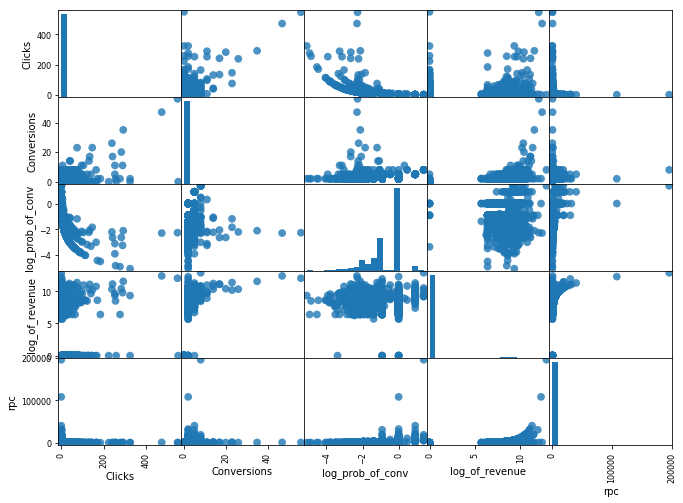

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

p = pd.plotting.scatter_matrix(pdf, figsize=(11, 8), marker='o',
                        hist_kwds={'bins': 20}, s=60, alpha=.8)

### Model probability of conversion

TODO's:

 - explode and save spark data frame &#9989;
 - baseline model
 - maximum and minimum attainable accuracy
 - add weighting of classes as a parameter to be tunned

#### Class balancing

In [11]:
tmp_0 = sdf_exp.filter(col('y')==0).agg(sum(col('n')).alias('n')).collect()[0].n
tmp_1 = sdf_exp.filter(col('y')==1).agg(sum(col('n')).alias('n')).collect()[0].n
p_0 = tmp_0 / (tmp_0 + tmp_1) * 100
print('Class percentage before weighting: Y==1: {:2.2f}%, Y==0: {:2.2f}%'.format(100 - p_0, p_0))

Class percentage before weighting: Y==1: 1.38%, Y==0: 98.62%


In [12]:
# class weights
N = tmp_0 + tmp_1
w_0 = N * .5 / tmp_0
w_1 = N * .5 / tmp_1

In [13]:
from pyspark.sql.functions import when

sdf_exp_w = sdf_exp \
            .withColumn('n', when(col('y') == 1, col('n') * w_1).otherwise(col('n') * w_0))
    
tmp_0 = sdf_exp_w.filter(col('y')==0).agg(sum(col('n')).alias('n')).collect()[0].n
tmp_1 = sdf_exp_w.filter(col('y')==1).agg(sum(col('n')).alias('n')).collect()[0].n
p_0 = tmp_0 / (tmp_0 + tmp_1) * 100
print('Class percentage after balancing: Y==1: {:2.2f}%, Y==0: {:2.2f}%'.format(100 - p_0, p_0))

Class percentage after balancing: Y==1: 50.00%, Y==0: 50.00%


#### Maximum attainable accuracy

$$ \frac{1}{C} \sum_{n = 1}^N c_n * \mathrm{max_y}\{c(y) \} $$

where $c(y)$ is a number of click events that ended with state $y$.

In [14]:
from pyspark.sql.functions import when

tmp = sdf_exp_w \
    .groupBy('Date', 'Keyword_ID', 'Match_type_ID') \
    .agg(*[sum('n').alias('Clicks'), sum(when(col('y')==1, col('n')).otherwise(0)).alias('Conversions')]) \
    .select('Conversions', 'Clicks') \
    .withColumn('score', when((col('Clicks') - col('Conversions')) > col('Conversions'), 
                              col('Clicks') - col('Conversions')).otherwise(col('Conversions'))) \
    .agg(sum(col('score')).alias('score'), sum(col('Clicks')).alias('Clicks')) \
    .collect()
    
print('Maximum possible accuracy: {:2.2f}%'.format(tmp[0].score / tmp[0].Clicks * 100) )

Maximum possible accuracy: 94.42%


#### Minimum attainable accuracy

In [15]:
tmp = sdf_exp_w \
    .groupBy('Date', 'Keyword_ID', 'Match_type_ID') \
    .agg(*[sum('n').alias('Clicks'), sum(when(col('y')==1, col('n')).otherwise(0)).alias('Conversions')]) \
    .select('Conversions', 'Clicks') \
    .withColumn('score', col('Clicks') - col('Conversions')) \
    .agg(sum(col('score')).alias('score'), sum(col('Clicks')).alias('Clicks')) \
    .collect()
    
print('Class majority accuracy: {:2.2f}%'.format(tmp[0].score / tmp[0].Clicks * 100) )

Class majority accuracy: 50.00%


### Average probability of conversion over time

In [16]:
tmp = sdf \
        .groupBy('Date') \
        .agg(*[sum(col('Conversions')).alias('Conversions'), 
           sum(col('Clicks')).alias('Clicks'), 
           sum(col('Revenue')).alias('Revenue')]) \
        .withColumn('log_prob_of_conv', log(col('Conversions') / col('Clicks'))) \
        .withColumn('prob_of_conv', col('Conversions') / col('Clicks')) \
        .withColumn('log_of_revenue', log(1 + col('Revenue'))) \
        .withColumn('rpc', log(col('Revenue') / col('Clicks'))) \
        .orderBy(col('Date').asc()) \
        .toPandas()

/home/ubuntu/.local/share/virtualenvs/ml-rpc-LO9Wo36E/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


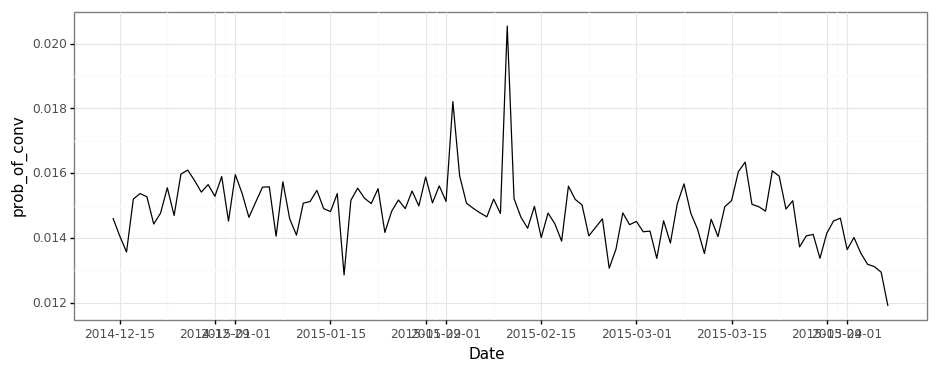

<ggplot: (-9223363280908143058)>

In [17]:
from plotnine import ggplot, geom_line, aes, theme_bw
import plotnine
plotnine.options.figure_size = (11, 4)


ggplot(aes(x='Date', y='prob_of_conv'), data=tmp) + geom_line() + theme_bw()

### Baseline model for `P[Conversion]`: Logistic regression

http://docs.h2o.ai/h2o/latest-stable/h2o-docs/booklets/GLMBooklet.pdf  
http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html

In [18]:
import h2o
from pysparkling import H2OContext
hc = H2OContext.getOrCreate(spark)

Connecting to H2O server at http://172.31.41.12:54321... successful.


H2O cluster uptime:,05 secs
H2O cluster version:,3.16.0.2
H2O cluster version age:,26 days
H2O cluster name:,sparkling-water-ubuntu_local-1514380256064
H2O cluster total nodes:,1
H2O cluster free memory:,10.67 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://172.31.41.12:54321
H2O connection proxy:,None



Sparkling Water Context:
 * H2O name: sparkling-water-ubuntu_local-1514380256064
 * cluster size: 1
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (driver,172.31.41.12,54321)
  ------------------------

  Open H2O Flow in browser: http://172.31.41.12:54321 (CMD + click in Mac OSX)

    


In [19]:
df = hc.as_h2o_frame(sdf_exp_w.sample(fraction=.1, seed=2014, withReplacement=False))

In [22]:
df

Date,Keyword_ID,Ad_group_ID,Campaign_ID,Account_ID,Device_ID,Match_type_ID,Revenue,Clicks,Conversions,n,y,m
2015-02-14 00:00:00,613188905043,1039018244603,2.24921e+11,8.66124e+11,2.98644e+11,9.57255e+10,0,11,0,5.57684,0,0
2015-02-15 00:00:00,651456920078,599787098040,1.80781e+11,2.1278e+11,8.4878e+11,9.57255e+10,0,2,0,1.01397,0,0
2015-02-15 00:00:00,436148050277,544194608471,7.8505e+11,2.1278e+11,1.07772e+12,9.57255e+10,0,5,0,2.53493,0,0
2015-02-15 00:00:00,531509950105,383115386558,3.08618e+11,1.51665e+11,8.4878e+11,9.57255e+10,0,8,0,4.05588,0,0
2015-02-15 00:00:00,517753208066,796281407100,9.19168e+11,2.1278e+11,1.07772e+12,8.94414e+11,0,2,0,1.01397,0,0
2015-02-15 00:00:00,193345433025,459423427446,5.35589e+11,6.5487e+11,1.07772e+12,9.57255e+10,0,5,0,2.53493,0,0
2015-02-15 00:00:00,1040455937355,674249907809,1.84219e+11,2.21354e+11,8.4878e+11,8.94414e+11,0,2,0,1.01397,0,0
2015-02-15 00:00:00,826047552533,746720565219,5.5128e+11,2.1278e+11,8.4878e+11,9.57255e+10,0,2,0,1.01397,0,0
2015-02-15 00:00:00,676133823720,873951396261,6.18753e+11,2.1278e+11,8.4878e+11,9.57255e+10,0,8,0,4.05588,0,0
2015-02-15 00:00:00,823513706874,374847310558,9.82714e+11,8.61287e+11,2.98644e+11,9.57255e+10,0,2,0,1.01397,0,0


In [37]:
df['Keyword_ID'] = df['Keyword_ID'].asfactor()
df['Ad_group_ID'] = df['Ad_group_ID'].asfactor()
df['Campaign_ID'] = df['Campaign_ID'].asfactor()
df['Match_type_ID'] = df['Match_type_ID'].asfactor()

In [38]:
tmp = df['Campaign_ID']
len(tmp.categories())

2358

In [98]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

predictors = ['Keyword_ID', 'Campaign_ID', 'Match_type_ID']
# int_list = ['Campaign_ID', 'Match_type_ID']
response = 'y'
weights_col = 'n'

glm_model = H2OGeneralizedLinearEstimator(family= "binomial", lambda_ = .0000000001, standardize = True ,alpha = 1.0)
glm_model.train(predictors, response, training_frame=df, weights_column='n')

glm Model Build progress: |███████████████████████████████████████████████| 100%


/home/ubuntu/.local/share/virtualenvs/ml-rpc-LO9Wo36E/lib/python3.5/site-packages/h2o/job.py:69: UserWarning: Reached maximum number of iterations 50!
  warnings.warn(w)


In [99]:
glm_model

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_model_python_1514380425483_40


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.16919941332646565
RMSE: 0.4113385628973603
LogLoss: 0.5144361906632796
Null degrees of freedom: 837122
Residual degrees of freedom: 620423
Null deviance: 3886788.6368275704
Residual deviance: 2884681.079644884
AIC: 3318081.079644884
AUC: 0.8408406944780964
Gini: 0.6816813889561928
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43639804451074704: 


,0,1,Error,Rate
0,943158.0,460987.0,0.3283,(460987.0/1404145.0)
1,189749.0,1209835.0,0.1356,(189749.0/1399584.0)
Total,1132907.0,1670822.0,0.2321,(650736.0/2803729.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4363980,0.7880618,214.0
max f2,0.3176808,0.8687730,277.0
max f0point5,0.5002283,0.7685407,181.0
max accuracy,0.4536893,0.7717002,205.0
max precision,0.9908529,0.9827269,0.0
max recall,0.0273226,1.0,395.0
max specificity,0.9908529,0.9999859,0.0
max absolute_mcc,0.4457613,0.5490666,209.0
max min_per_class_accuracy,0.4984316,0.7682076,182.0
max mean_per_class_accuracy,0.4536893,0.7718136,205.0


Gains/Lift Table: Avg response rate: 51.33 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0103422,0.9233707,1.7846686,1.7846686,0.9159856,0.9159856,0.0184574,0.0184574,78.4668626,78.4668626
,2,0.0265559,0.8974591,1.7462753,1.7612276,0.8962801,0.9039544,0.0283136,0.0467709,74.6275292,76.1227586
,3,0.0310096,0.8912956,1.7613707,1.7612481,0.9040278,0.9039650,0.0078447,0.0546156,76.1370668,76.1248136
,4,0.0410159,0.8872760,1.7060807,1.7477894,0.8756502,0.8970572,0.0170716,0.0716872,70.6080737,74.7789416
,5,0.0532070,0.8801303,1.7190604,1.7412069,0.8823120,0.8936787,0.0209572,0.0926444,71.9060362,74.1206854
,6,0.1026235,0.8319082,1.7059037,1.7242072,0.8755593,0.8849536,0.0842999,0.1769443,70.5903672,72.4207229
,7,0.1536757,0.7671246,1.6534215,1.7006917,0.8486227,0.8728842,0.0844106,0.2613549,65.3421480,70.0691719
,8,0.2047484,0.7169291,1.6486124,1.6877010,0.8461544,0.8662167,0.0841992,0.3455541,64.8612429,68.7700978
,9,0.3061358,0.6356226,1.5331840,1.6365274,0.7869105,0.8399517,0.1554455,0.5009996,53.3184031,63.6527385
,10,0.4071689,0.5668473,1.3740187,1.5713897,0.7052185,0.8065196,0.1388213,0.6398209,37.4018734,57.1389675



Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2017-12-27 13:52:59,0.000 sec,0,1943394.3184138,0.6931459
,2017-12-27 13:53:00,0.655 sec,1,1908584.3532165,0.6807303
,2017-12-27 13:53:00,0.879 sec,2,1898466.9275342,0.6771217
,2017-12-27 13:53:00,1.031 sec,3,1841386.5368891,0.6567630
,2017-12-27 13:53:00,1.169 sec,4,1823875.0006360,0.6505172
---,---,---,---,---,---
,2017-12-27 13:53:06,7.216 sec,46,1446534.1846430,0.5159327
,2017-12-27 13:53:06,7.364 sec,47,1448681.7950776,0.5166987
,2017-12-27 13:53:07,7.491 sec,48,1449046.8475006,0.5168289
,2017-12-27 13:53:07,7.632 sec,49,1447036.3825581,0.5161118



See the whole table with table.as_data_frame()


In [ ]:
glm_model.std_coef_plot(nu)